In [112]:
import mne
import numpy as np

from mne import set_log_level

from mne_lsl.player import PlayerLSL as Player
from mne_lsl.stream import StreamLSL as Stream

set_log_level("WARNING")

eeg_path = r'C:\Users\Victor\Documents\GitHub\neuxus_test\P05_eyes_open_mrion.vhdr'
raw = mne.io.read_raw_brainvision(eeg_path, preload=True)

player = Player(raw).start()
player.info

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Victor\\Documents\\GitHub\\neuxus_test\\P05_eyes_closed_mrion.vhdr'

In [2]:
tr = 1.6
n_tr = 7

bufsize = (n_tr + 1) * tr
stream = Stream(bufsize=bufsize, name='MNE-LSL-Player').connect()
stream.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,36 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,5000.00 Hz
Highpass,0.02 Hz
Lowpass,250.00 Hz


C:\Users\Victor\AppData\Local\Temp\ipykernel_17732\466342801.py:3: RuntimeWarning: The unit for channel(s) CWL1, CWL2, CWL3, CWL4 has changed from V to NA.
  raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})


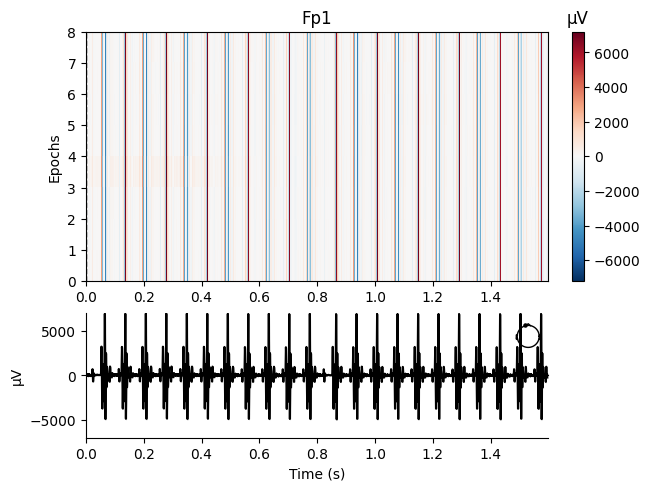

In [6]:
data, timestamps = stream.get_data(bufsize * stream.info['sfreq'])
raw = mne.io.RawArray(data, stream.info)
raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})
raw.set_montage('standard_1020')

epochs = mne.make_fixed_length_epochs(raw, duration=tr, overlap=0, preload=True)
average = epochs[:-1].average(picks='all')
clean_epoch_data = epochs[-1].get_data(picks=average.ch_names)[0] - average.data

ga_corrected = mne.io.RawArray(clean_epoch_data, epochs.info)
event_related_plot = epochs.plot_image(picks=["Fp1"])

In [110]:
import time 

picks=['eeg']
cwl_ch_names=['CWL1', 'CWL2', 'CWL3', 'CWL4']

cwl_correction = CWLCorrection(stream.info, cwl_ch_names, picks=picks, min_lag=-0.06, max_lag=0.06)

raws = list()

for i in range(100):
    data, timestamps = stream.get_data(bufsize * stream.info['sfreq'])
    raw = mne.io.RawArray(data, stream.info)
    raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})

    epochs = mne.make_fixed_length_epochs(raw, duration=tr, overlap=0, preload=True)
    average = epochs[:-1].average(picks='all')
    clean_epoch_data = epochs[-1].get_data(picks=average.ch_names)[0] - average.data
    ga_corrected = mne.io.RawArray(clean_epoch_data, epochs.info)

    raw_ = ga_corrected.copy().resample(100)

    raw_corrected = cwl_correction.correct(raw_)
    raws.append(raw_corrected)
    time.sleep(0.5 * tr)
    

C:\Users\Victor\AppData\Local\Temp\ipykernel_17732\486612492.py:13: RuntimeWarning: The unit for channel(s) CWL1, CWL2, CWL3, CWL4 has changed from V to NA.
  raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})
C:\Users\Victor\AppData\Local\Temp\ipykernel_17732\486612492.py:13: RuntimeWarning: The unit for channel(s) CWL1, CWL2, CWL3, CWL4 has changed from V to NA.
  raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})
C:\Users\Victor\AppData\Local\Temp\ipykernel_17732\486612492.py:13: RuntimeWarning: The unit for channel(s) CWL1, CWL2, CWL3, CWL4 has changed from V to NA.
  raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})
C:\Users\Victor\AppData\Local\Temp\ipykernel_17732\486612492.py:13: RuntimeWarning: The unit for channel(s) CWL1, CWL2, CWL3, CWL4 has changed from V to NA.
  raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CW

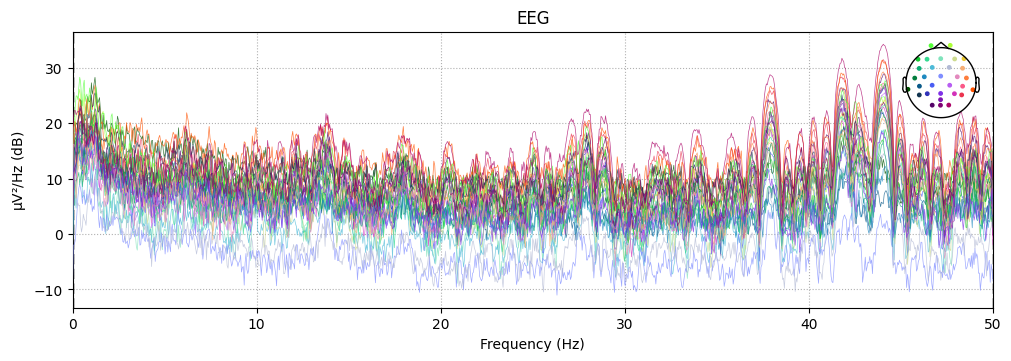

In [113]:
raw_all = mne.concatenate_raws(raws)
raw_all.compute_psd().plot(dB=True)

In [ ]:
raw.copy().crop(tmin=raw.times[-1] - tr).plot()
ga_corrected.plot(scalings='auto')

In [99]:
from numba import jit, njit, prange
from numpy.linalg import lstsq


@njit(nopython=True, parallel=True)
def create_time_lag_signals(Y, sample_freq, min_lag, max_lag):
    # Calculate number of samples for each lag
    num_samples = int((max_lag - min_lag) * sample_freq) + 1
    # Initialize array to store time lag signals
    time_lag_signals = np.zeros((num_samples, Y.shape[0], Y.shape[1]))
    # Iterate through each lag value and generate time lagged signals
    lags = np.linspace(min_lag, max_lag, num_samples)
    for l in prange(len(lags)):
        lag = lags[l]
        # Calculate index offset based on time lag
        offset = int(round(lag * sample_freq))
        # Shift signal Y by the offset
        shifted_Y = np.roll(Y, offset)
        # Clip the shifted signal to match the length of X
        if offset > 0:
            shifted_Y[:offset] = Y[0]
        elif offset < 0:
            shifted_Y[offset:] = Y[-1]
        
        # Store the time lagged signal
        time_lag_signals[l] = shifted_Y
    time_lag_signals = time_lag_signals.reshape(-1, Y.shape[1])
    return time_lag_signals


@njit(nopython=True, parallel=True)
def compute_regression(X, Y):
    ## Sk implementation
    X_offset = np.average(X, axis=0)
    X -= X_offset

    n_samples, n_channels =  Y.shape
    residuals = np.zeros_like(Y)
    for c in prange(n_channels):
        y = Y[:, c]
        y_offset = np.average(y, axis=0)
        y -= y_offset
        #y = y.reshape(-1, 1)
        coef_, resids, rank, s = lstsq(X, y, rcond=-1)
        resid = y - np.dot(X, coef_)
        residuals[:, c] = resid.reshape(-1)
    return residuals.T


class CWLCorrection():

    def __init__(self, info, cwl_ch_names, picks=['eeg', 'ecg'], min_lag=-0.1, max_lag=0.1):

        self.pick_indices = mne._fiff.pick._picks_to_idx(raw.info, picks=picks)
        self.cwl_indices = mne._fiff.pick._picks_to_idx(raw.info, picks=cwl_ch_names)
        self.sfreq = info['sfreq']
        self.min_lag = min_lag
        self.max_lag = max_lag

    def correct(self, raw):
        data = raw.get_data()
        X = data[self.cwl_indices]
        Y = data[self.pick_indices]

        X = create_time_lag_signals(X, self.sfreq, self.min_lag, self.max_lag)
        residuals = compute_regression(X.T, Y.T)

        data[self.pick_indices] = residuals
        raw = mne.io.RawArray(data, raw.info)
        return(raw)

    def correct_sm(self, raw):
        import statsmodels.api as sm
        data = raw.get_data()
        X = data[self.cwl_indices]
        Y = data[self.pick_indices]
        X = create_time_lag_signals(X, self.sfreq, self.min_lag, self.max_lag)

        for pick in self.pick_indices:
            y = data[pick, :]
            model = sm.OLS(y.T, X.T)
            results = model.fit()
            residuals = results.resid
            data[pick] = residuals
        raw = mne.io.RawArray(data, raw.info)
        return(raw)

C:\Users\Victor\AppData\Roaming\Python\Python310\site-packages\numba\core\decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [104]:
picks=['eeg']
cwl_ch_names=['CWL1', 'CWL2', 'CWL3', 'CWL4']

raw_ = ga_corrected.copy().resample(100)
cwl_correction = CWLCorrection(raw_.info, cwl_ch_names, picks=picks, min_lag=-0.06, max_lag=0.06)

raw_corrected = cwl_correction.correct(raw_)

In [105]:
%timeit raw_corrected = cwl_correction.correct(raw_)

202 ms ± 62.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
raw_corrected.plot()

d:\Python\envs\mne_lsl\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


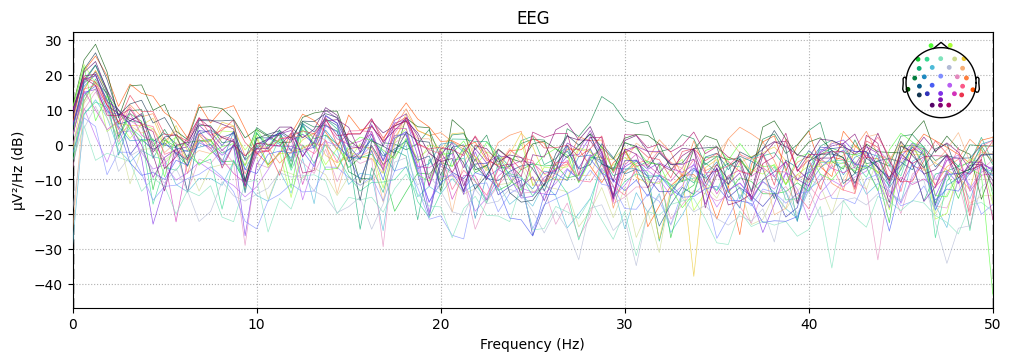

In [106]:
raw_ = ga_corrected.copy().resample(100)
raw_corrected_sk = cwl_correction.correct_sm(raw_)
raw_corrected.compute_psd(fmin=0, fmax=50).plot();
#raw_corrected.plot();

d:\Python\envs\mne_lsl\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


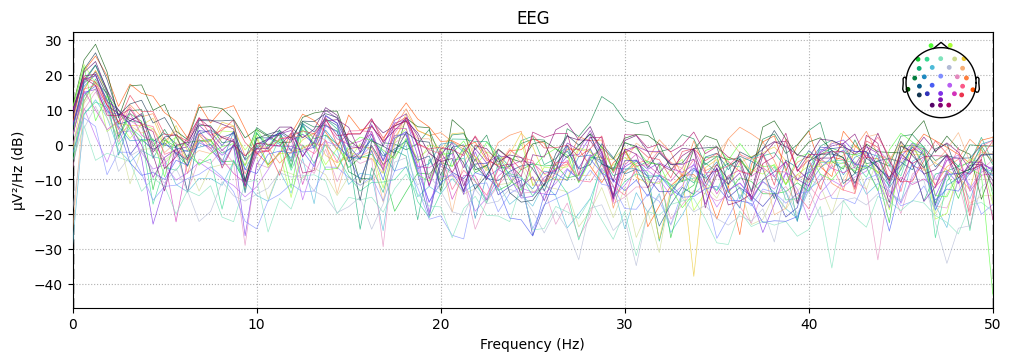

In [107]:
raw_ = ga_corrected.copy().resample(100)
raw_corrected = cwl_correction.correct(raw_)
raw_corrected.compute_psd(fmin=0, fmax=50).plot();
#raw_corrected.plot();

In [108]:
%matplotlib qt
raw_corrected.compute_psd(fmin=0, fmax=50).plot();